<a href="https://colab.research.google.com/github/JochiSt/AI_PulseReconstruction/blob/main/TestSTM32_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pulse recognition AI

first all the imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt

## Generate template

In [4]:
TOTAL_SAMPLES = 128

def generateTemplate(position = 0, pulse_length = 32, height=1, noise=0):

  assert TOTAL_SAMPLES - pulse_length - position > 0

  template = np.append(np.zeros(position), np.ones(pulse_length))
  template = np.append(template, np.zeros( TOTAL_SAMPLES - pulse_length - position))

  template *= height

  # add some noise
  template  += noise * np.random.randn(*template.shape)
  template = template.astype(int)

  return template

print("template length: ", len(generateTemplate()))

template length:  128


Have a look at the template visually

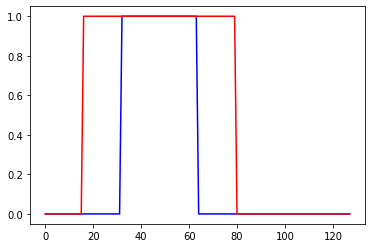

In [5]:
plt.plot(generateTemplate(position = 32, pulse_length=32), 'b')
plt.plot(generateTemplate(position = 16, pulse_length=64), 'r')
plt.show()

add some noise, and maybe shift the position





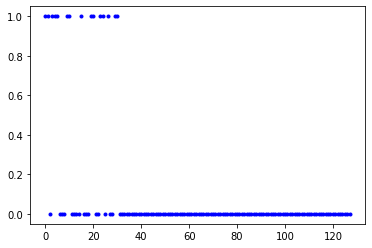

In [6]:
# Plot our data
plt.plot(generateTemplate(noise=0.1), 'b.')
plt.show()

## Create Templates for recognision

Generate a couple of templates, which have a pulse in them, and some without any data

17 41 1.7 120
49 53 0.6 119
43 33 2.3 90
82 23 2.0 122
24 61 1.1 126
11 61 2.7 124
24 47 0.1 63
38 63 2.0 82
47 63 0.1 122
41 17 0.7 117


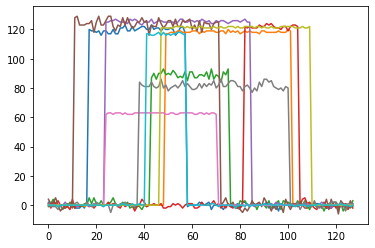

In [7]:
for i in range(10):
  width = np.random.randint(16, 64)               # width of 16 to 64
  position = np.random.randint(0, high=128-width) # arbitrary position
  noise = np.random.randint(1,30)/10.             # 0.1 to 3 LSB noise
  height = np.random.randint(32,128)              # pulse height of 32 to 128

  print(position, width, noise, height)
  plt.plot(generateTemplate(position = position, pulse_length = width, height=height, noise=noise))

plt.show()

# Building the ANN


### Purpose of the ANN
We want to do Pattern Recognition, based on the waveforms shown above.

The output parameters, which we want to reconstruct are:
*   Width
*   Position
*   height


Starting with importing all things, which we need for creating a model

In [8]:
# TensorFlow is an open source machine learning library
import tensorflow as tf
# Keras is TensorFlow's high-level API for deep learning
from tensorflow import keras

In [9]:
# use 1000 samples for testing
SAMPLES = 1000

## Generate the samples
We want to do Pattern recognition, so we have to link the waveforms to the input parameters.

In [10]:
# use fixed value for noise (1st try)
noise = 0.4 

y_values = []
x_values = []

# generate the waveforms
for i in range(SAMPLES):
  # use random settings
  width = np.random.randint(16, 64)               # width of 16 to 64
  position = np.random.randint(0, high=128-width) # arbitrary position
  height = np.random.randint(32,128)              # pulse height of 32 to 128

  x_values.append( (width, position, height) )
  y_values.append( generateTemplate(position = position, pulse_length = width, height=height, noise=noise) )

# debug printouts
print(x_values[:2])
print(y_values[:2])

[(17, 24, 97), (17, 80, 107)]
[array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, 96, 97, 96, 96, 97, 97, 96, 95, 96, 97,
       96, 97, 96, 96, 97, 97, 97,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0]), array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   

### Look at the training data
Just make a 2D histogram of all templates.

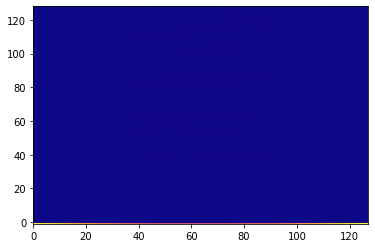

In [15]:
plot_x = [ np.arange(128) for i in range(len(y_values)) ]
plot_x = np.array(plot_x)
plot_x = plot_x.flatten()
plot_y = np.array(y_values)
plot_y = plot_y.flatten()
plt.hist2d(plot_x, plot_y, bins=128, cmap='plasma')
plt.show()

## Split the waveforms into Training, Testing and Validation

In [16]:
# We'll use 60% of our data for training and 20% for testing. The remaining 20%
# will be used for validation. Calculate the indices of each section.
TRAIN_SPLIT =  int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)
print("using %d points for training and %d points for testing"%(TRAIN_SPLIT, TEST_SPLIT))

# convert data into numpy arrays
y_values = np.array(y_values)
x_values = np.array(x_values)

# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# Double check that our splits add up correctly
assert (len(x_train) + len(x_validate) + len(x_test) ) ==  SAMPLES

using 600 points for training and 800 points for testing


## Create the ANN

In [23]:
inputs = keras.Input(shape=(128,), name="waveform input")

x = keras.layers.Dense(64, activation="relu", name="dense_1")(inputs)
x = keras.layers.Dense(16, activation="relu", name="dense_2")(x)
x = keras.layers.Dense(9, activation="relu", name="dense_3")(x)
outputs = keras.layers.Dense(3, activation="softmax", name="classification")(x)

model_1 = keras.Model(inputs=inputs, outputs=outputs)
model_1.summary()

# Compile the model using the standard 'adam' optimizer and the mean squared error or 'mse' loss function for regression.
model_1.compile(optimizer='adam', loss='mse', metrics=['mae'])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 waveform input (InputLayer)  [(None, 128)]            0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 9)                 153       
                                                                 
 classification (Dense)      (None, 3)                 30        
                                                                 
Total params: 9,479
Trainable params: 9,479
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [24]:
# Train the model on our training data while validating on our validation set
history_1 = model_1.fit(y_train, x_train, epochs=500, batch_size=64, validation_data=(y_validate, x_validate))

# Save the model to disk
#MODEL_TF="TestSTM32_AI"
#model_1.save(MODEL_TF)

Epoch 1/500
10/10 [==============================] - 1s 20ms/step - loss: 3760.2954 - mae: 53.7550 - val_loss: 3765.9238 - val_mae: 53.3783
Epoch 2/500
10/10 [==============================] - 0s 6ms/step - loss: 3760.2725 - mae: 53.7550 - val_loss: 3765.9204 - val_mae: 53.3783
Epoch 3/500
10/10 [==============================] - 0s 5ms/step - loss: 3760.2620 - mae: 53.7550 - val_loss: 3765.9189 - val_mae: 53.3783
Epoch 4/500
10/10 [==============================] - 0s 7ms/step - loss: 3760.2505 - mae: 53.7550 - val_loss: 3765.8359 - val_mae: 53.3783
Epoch 5/500
10/10 [==============================] - 0s 4ms/step - loss: 3760.0459 - mae: 53.7550 - val_loss: 3765.6016 - val_mae: 53.3783
Epoch 6/500
10/10 [==============================] - 0s 6ms/step - loss: 3759.9424 - mae: 53.7550 - val_loss: 3765.4885 - val_mae: 53.3783
Epoch 7/500
10/10 [==============================] - 0s 4ms/step - loss: 3759.9568 - mae: 53.7550 - val_loss: 3765.2957 - val_mae: 53.3783
Epoch 8/500
10/10 [=======

### Evaluate the training performance

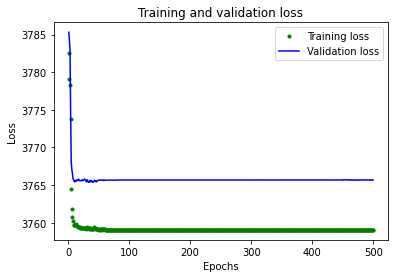

In [22]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()